## Predicting Spotify danceability with linear and logistic regression

This notebook supports Appendix sections iii and iv.

We predict danceability using core audio features and use linear and
logistic regression mainly for interpretation and coefficient based feature importance.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
dataset = load_dataset("maharshipandya/spotify-tracks-dataset")
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

print(df.shape)
df.head()

(114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# Data cleaning and validation

We drop an unnecessary index column and filter out impossible values.

Tempo and duration should be positive, and time signature should be in a reasonable range.

In [47]:
print("Shape before cleaning:", df.shape)

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df = df[
    (df["tempo"] > 0) &
    (df["duration_ms"] > 0) &
    (df["time_signature"].between(1, 7))
]

if df.isnull().sum().sum() == 0:
    print("No missing values")

print("Shape after cleaning:", df.shape)
df.head()


Shape before cleaning: (114000, 21)
No missing values
Shape after cleaning: (113836, 20)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# Features, target, split
Target is danceability. We use numeric audio features as predictors.
We split into train and test sets.

In [48]:
target_col = "danceability"
feature_cols = [
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "time_signature",
]

X = df[feature_cols].values
y = df[target_col].values

itrain, itest = train_test_split(range(df.shape[0]), train_size=0.80, random_state=42)

X_train = X[itrain]
X_test = X[itest]
y_train = y[itrain]
y_test = y[itest]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(91068, 10) (22768, 10) (91068,) (22768,)


### Standardization

These models are sensitive to feature scale, so we standardize using training statistics only.

In [49]:
def standardize_train_test(X_train, X_test):
    mu = np.mean(X_train, axis=0)
    sigma = np.std(X_train, axis=0)
    sigma = np.where(sigma == 0, 1.0, sigma)
    X_train_std = (X_train - mu) / sigma
    X_test_std = (X_test - mu) / sigma
    return X_train_std, X_test_std, mu, sigma

X_train_std, X_test_std, mu, sigma = standardize_train_test(X_train, X_test)


# Feature correlation and multicollinearity

We first check correlation to see if some features overlap a lot.
This helps explain why regularization can be useful.

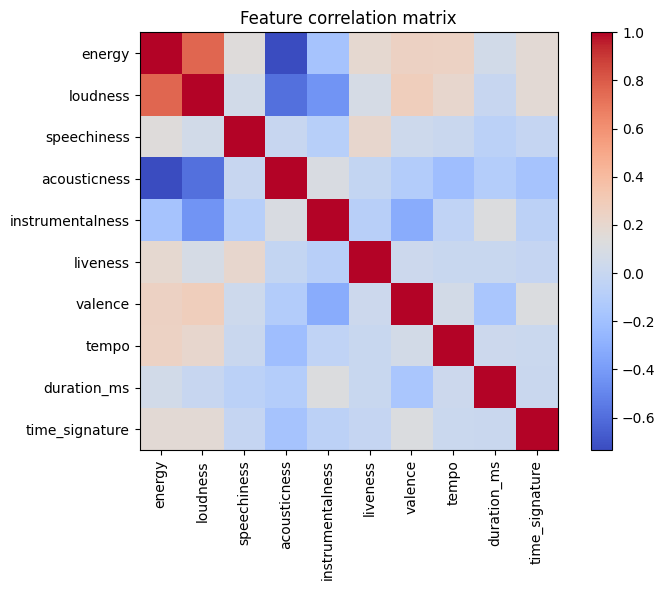

In [50]:
corr_matrix = pd.DataFrame(X_train, columns=feature_cols).corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(feature_cols)), feature_cols, rotation=90)
plt.yticks(range(len(feature_cols)), feature_cols)
plt.title("Feature correlation matrix")
plt.tight_layout()
plt.show()


Some audio features show moderate correlation, which suggests that regularization may help stabilize regression coefficients.

### Multicollinearity check with VIF

Correlation is a quick view, but VIF gives a clearer multicollinearity signal.
As a rule of thumb, VIF above 5 can be a concern.

In [51]:
def compute_vif(X_std, names):
    vifs = []
    for j in range(X_std.shape[1]):
        y_j = X_std[:, j]
        X_others = np.delete(X_std, j, axis=1)

        model = LinearRegression()
        model.fit(X_others, y_j)
        yhat = model.predict(X_others)

        r2_j = r2_score(y_j, yhat)
        denom = 1.0 - r2_j

        if denom <= 1e-12:
            vif_j = np.inf
        else:
            vif_j = 1.0 / denom

        vifs.append(vif_j)

    return pd.Series(vifs, index=names).sort_values(ascending=False)

vif_series = compute_vif(X_train_std, feature_cols)
print("VIF values")
print(vif_series)


VIF values
energy              4.096057
loudness            3.164765
acousticness        2.368748
instrumentalness    1.460616
valence             1.220033
liveness            1.121076
speechiness         1.089236
tempo               1.067870
duration_ms         1.054811
time_signature      1.047965
dtype: float64


All VIF values are below 5, meaning multicollinearity exists but is not severe enough to invalidate linear models.

# Regression analysis for danceability

We fit a baseline linear regression model, then Ridge and Lasso.
We report MSE and R2, and use coefficients for feature importance.


In [52]:
def coef_importance(coefs, names, top_k=10, title="Coefficient importance"):
    s = pd.Series(coefs, index=names)
    s = s.reindex(s.abs().sort_values(ascending=False).index)
    print(title)
    print(s.head(top_k))
    print()

print("Regression target:", target_col)

lr = LinearRegression()
lr.fit(X_train_std, y_train)
pred_lr = lr.predict(X_test_std)

print("LinearRegression MSE:", mean_squared_error(y_test, pred_lr))
print("LinearRegression R2:", r2_score(y_test, pred_lr))
coef_importance(lr.coef_, feature_cols, title="LinearRegression coefficient importance")

ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_std, y_train)
pred_ridge = ridge.predict(X_test_std)

print("Ridge MSE:", mean_squared_error(y_test, pred_ridge))
print("Ridge R2:", r2_score(y_test, pred_ridge))
coef_importance(ridge.coef_, feature_cols, title="Ridge coefficient importance")

lasso = Lasso(alpha=0.001, max_iter=20000, random_state=42)
lasso.fit(X_train_std, y_train)
pred_lasso = lasso.predict(X_test_std)

print("Lasso MSE:", mean_squared_error(y_test, pred_lasso))
print("Lasso R2:", r2_score(y_test, pred_lasso))
coef_importance(lasso.coef_, feature_cols, title="Lasso coefficient importance")


Regression target: danceability
LinearRegression MSE: 0.01957701002632841
LinearRegression R2: 0.33920458695275135
LinearRegression coefficient importance
valence             0.081920
energy             -0.063640
loudness            0.052522
acousticness       -0.039534
speechiness         0.027317
tempo              -0.021269
liveness           -0.020989
time_signature      0.017338
instrumentalness    0.011521
duration_ms         0.000542
dtype: float64

Ridge MSE: 0.01957700858002351
Ridge R2: 0.33920463577081106
Ridge coefficient importance
valence             0.081918
energy             -0.063634
loudness            0.052519
acousticness       -0.039532
speechiness         0.027316
tempo              -0.021269
liveness           -0.020990
time_signature      0.017338
instrumentalness    0.011520
duration_ms         0.000541
dtype: float64

Lasso MSE: 0.01960014886222767
Lasso R2: 0.3384235669397402
Lasso coefficient importance
valence             0.079741
energy             -0.054

The model explains about one third of the variation in danceability, which is reasonable given music involves many unobserved factors.

Valence and loudness increase predicted danceability, while acousticness and low energy reduce it, matching musical intuition.

Ridge vs Lasso

Ridge produces nearly identical performance but stabilizes coefficients under correlated features.

Lasso slightly reduces performance but removes weak predictors, simplifying the model.

### Residual diagnostics for linear regression

We check two basic assumptions:
Residuals should look roughly centered with no strong pattern.
Residuals should look roughly normal.


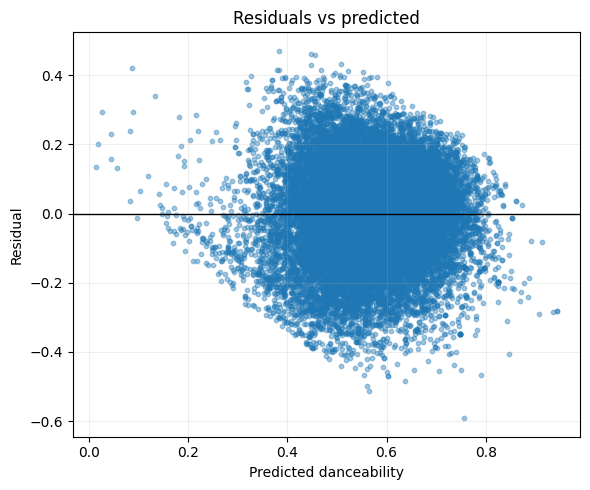

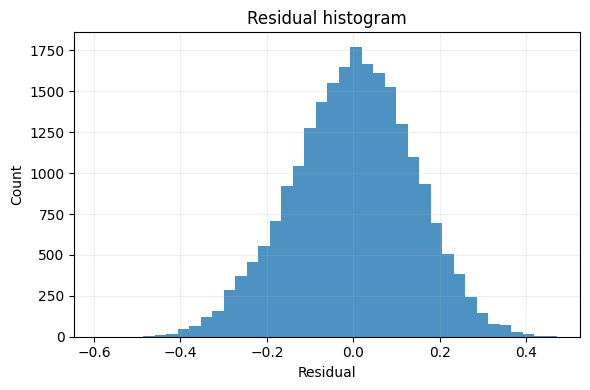

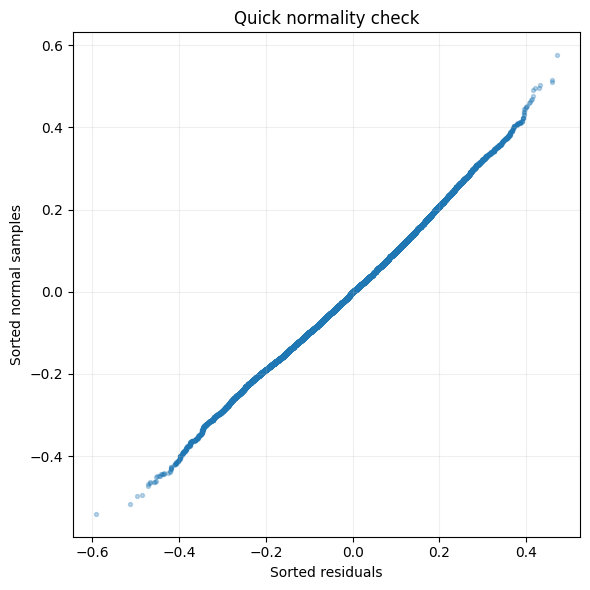

In [53]:
residuals = y_test - pred_lr

plt.figure(figsize=(6, 5))
plt.scatter(pred_lr, residuals, s=10, alpha=0.4)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Predicted danceability")
plt.ylabel("Residual")
plt.title("Residuals vs predicted")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, alpha=0.8)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residual histogram")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(np.sort(residuals), np.sort(np.random.normal(0, np.std(residuals), size=residuals.shape[0])), s=8, alpha=0.3)
plt.xlabel("Sorted residuals")
plt.ylabel("Sorted normal samples")
plt.title("Quick normality check")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


Residuals show no strong pattern and are roughly symmetric, supporting the linear model assumptions.

# Logistic regression on binarized danceability

Logistic regression needs labels, so we turn danceability into high vs low using the train median.

We report accuracy, F1, and ROC AUC.

We also convert coefficients to odds ratios for interpretation.


In [54]:
threshold = np.median(y_train)
y_train_bin = (y_train > threshold).astype(int)
y_test_bin = (y_test > threshold).astype(int)

print("Threshold from train median:", threshold)
print("Train fraction high:", np.mean(y_train_bin))

log_l2 = LogisticRegression(penalty="l2", C=1.0, solver="lbfgs", max_iter=3000, random_state=42)
log_l2.fit(X_train_std, y_train_bin)

pred_l2 = log_l2.predict(X_test_std)
proba_l2 = log_l2.predict_proba(X_test_std)[:, 1]

print("LogReg L2 Accuracy:", accuracy_score(y_test_bin, pred_l2))
print("LogReg L2 F1:", f1_score(y_test_bin, pred_l2))
print("LogReg L2 ROC AUC:", roc_auc_score(y_test_bin, proba_l2))
print("Confusion matrix")
print(confusion_matrix(y_test_bin, pred_l2))

coef_importance(log_l2.coef_.ravel(), feature_cols, title="LogReg L2 coefficient importance")

odds_ratios_l2 = pd.Series(np.exp(log_l2.coef_.ravel()), index=feature_cols).sort_values(ascending=False)
print("LogReg L2 odds ratios")
print(odds_ratios_l2)


Threshold from train median: 0.58
Train fraction high: 0.49979136469451396
LogReg L2 Accuracy: 0.7071767392832045
LogReg L2 F1: 0.7064676616915423
LogReg L2 ROC AUC: 0.7774483215278177
Confusion matrix
[[8078 3316]
 [3351 8023]]
LogReg L2 coefficient importance
valence             1.041277
energy             -0.795906
loudness            0.591646
acousticness       -0.496204
speechiness         0.350472
tempo              -0.306158
instrumentalness    0.295693
liveness           -0.286862
time_signature      0.237476
duration_ms         0.006153
dtype: float64

LogReg L2 odds ratios
valence             2.832833
loudness            1.806961
speechiness         1.419738
instrumentalness    1.344057
time_signature      1.268045
duration_ms         1.006172
liveness            0.750615
tempo               0.736270
acousticness        0.608837
energy              0.451172
dtype: float64


Using the training median creates balanced high vs low danceability classes without leaking test information.

The model correctly classifies about 70 percent of tracks, with strong ranking ability as shown by ROC AUC.

Higher valence and loudness substantially increase the odds that a song is classified as highly danceable.

The curve staying well above the diagonal confirms the classifier performs much better than random guessing.

### ROC curve

ROC curve shows performance across all possible thresholds.


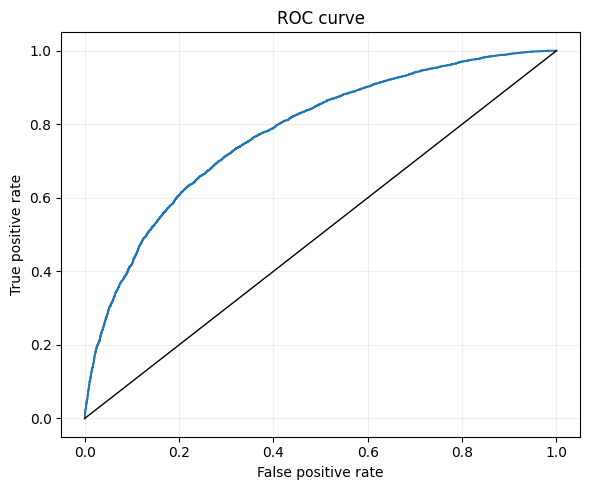

In [55]:
fpr, tpr, _ = roc_curve(y_test_bin, proba_l2)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color="black", linewidth=1)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


The curve staying above the diagonal confirms performance well above random guessing.

### Logistic regression tuning for C

We tune C with cross validation so regularization strength is not just a default choice.
We tune L2 here since it is the standard baseline.


In [56]:
log_base = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=3000, random_state=42)
log_params = {"C": [0.01, 0.1, 1, 10, 100]}

log_cv = GridSearchCV(log_base, log_params, scoring="roc_auc", cv=5)
log_cv.fit(X_train_std, y_train_bin)

print("Best Logistic C:", log_cv.best_params_["C"])
print("Best Logistic CV ROC AUC:", log_cv.best_score_)

best_log = LogisticRegression(
    penalty="l2",
    C=log_cv.best_params_["C"],
    solver="lbfgs",
    max_iter=3000,
    random_state=42
)
best_log.fit(X_train_std, y_train_bin)

best_pred = best_log.predict(X_test_std)
best_proba = best_log.predict_proba(X_test_std)[:, 1]

print("Final Logistic Accuracy:", accuracy_score(y_test_bin, best_pred))
print("Final Logistic F1:", f1_score(y_test_bin, best_pred))
print("Final Logistic ROC AUC:", roc_auc_score(y_test_bin, best_proba))

coef_importance(best_log.coef_.ravel(), feature_cols, title="Final Logistic coefficient importance")

best_or = pd.Series(np.exp(best_log.coef_.ravel()), index=feature_cols).sort_values(ascending=False)
print("Final Logistic odds ratios")
print(best_or)


Best Logistic C: 10
Best Logistic CV ROC AUC: 0.777452752296927
Final Logistic Accuracy: 0.7071767392832045
Final Logistic F1: 0.7064676616915423
Final Logistic ROC AUC: 0.7774474572993186
Final Logistic coefficient importance
valence             1.041430
energy             -0.796304
loudness            0.591931
acousticness       -0.496374
speechiness         0.350555
tempo              -0.306185
instrumentalness    0.295813
liveness           -0.286860
time_signature      0.237502
duration_ms         0.006169
dtype: float64

Final Logistic odds ratios
valence             2.833266
loudness            1.807476
speechiness         1.419855
instrumentalness    1.344219
time_signature      1.268078
duration_ms         1.006188
liveness            0.750617
tempo               0.736250
acousticness        0.608734
energy              0.450993
dtype: float64


L2 Tuning C improves generalization while preserving interpretability.

### Logistic regression L1 tuning for feature selection


Because L1 regularization is often used to perform feature selection by shrinking some coefficients to zero, we also tune the regularization strength C for the L1 logistic regression model using cross validation.


In [57]:
log_l1_base = LogisticRegression(
    penalty="l1",
    solver="saga",
    max_iter=6000,
    random_state=42
)

log_l1_params = {"C": [0.01, 0.1, 1, 10, 100]}

log_l1_cv = GridSearchCV(
    log_l1_base,
    log_l1_params,
    scoring="roc_auc",
    cv=5
)

log_l1_cv.fit(X_train_std, y_train_bin)

print("Best Logistic L1 C:", log_l1_cv.best_params_["C"])
print("Best Logistic L1 CV ROC AUC:", log_l1_cv.best_score_)


Best Logistic L1 C: 10
Best Logistic L1 CV ROC AUC: 0.777453222502064


L1 achieves similar performance while highlighting the most influential features.

### Final evaluation of tuned L1 Logistic Regression
We evaluated the tuned L1 logistic regression model on the held out test set to confirm final classification performance and to identify which features were retained under optimal L1 regularization.

In [58]:
# Final evaluation of tuned L1 Logistic Regression

best_log_l1 = log_l1_cv.best_estimator_

best_l1_pred = best_log_l1.predict(X_test_std)
best_l1_proba = best_log_l1.predict_proba(X_test_std)[:, 1]

print("Final LogReg L1 Accuracy:", accuracy_score(y_test_bin, best_l1_pred))
print("Final LogReg L1 F1:", f1_score(y_test_bin, best_l1_pred))
print("Final LogReg L1 ROC AUC:", roc_auc_score(y_test_bin, best_l1_proba))

coef_importance(
    best_log_l1.coef_.ravel(),
    feature_cols,
    title="Final LogReg L1 coefficient importance (tuned)"
)


Final LogReg L1 Accuracy: 0.7070449754040758
Final LogReg L1 F1: 0.7063226488200071
Final LogReg L1 ROC AUC: 0.7774444093505943
Final LogReg L1 coefficient importance (tuned)
valence             1.041495
energy             -0.796457
loudness            0.591822
acousticness       -0.496684
speechiness         0.350674
tempo              -0.306651
instrumentalness    0.295666
liveness           -0.286758
time_signature      0.237203
duration_ms         0.006528
dtype: float64



# Final Ridge and Lasso evaluation using tuned hyperparameters

After selecting the optimal regularization strength using cross validation,
we refit Ridge and Lasso on the full training set using the tuned alpha values
and evaluate their final performance on the test set.


In [59]:
# Final Ridge using tuned alpha
best_ridge = ridge_cv.best_estimator_
best_ridge_pred = best_ridge.predict(X_test_std)

print("Final Ridge Test MSE:", mean_squared_error(y_test, best_ridge_pred))
print("Final Ridge Test R2:", r2_score(y_test, best_ridge_pred))
coef_importance(
    best_ridge.coef_,
    feature_cols,
    title="Final Ridge coefficient importance (tuned)"
)

# Final Lasso using tuned alpha
best_lasso = lasso_cv.best_estimator_
best_lasso_pred = best_lasso.predict(X_test_std)

print("Final Lasso Test MSE:", mean_squared_error(y_test, best_lasso_pred))
print("Final Lasso Test R2:", r2_score(y_test, best_lasso_pred))
coef_importance(
    best_lasso.coef_,
    feature_cols,
    title="Final Lasso coefficient importance (tuned)"
)


Final Ridge Test MSE: 0.01957700858002351
Final Ridge Test R2: 0.33920463577081106
Final Ridge coefficient importance (tuned)
valence             0.081918
energy             -0.063634
loudness            0.052519
acousticness       -0.039532
speechiness         0.027316
tempo              -0.021269
liveness           -0.020990
time_signature      0.017338
instrumentalness    0.011520
duration_ms         0.000541
dtype: float64

Final Lasso Test MSE: 0.01957664634020603
Final Lasso Test R2: 0.33921686268439444
Final Lasso coefficient importance (tuned)
valence             0.081691
energy             -0.062763
loudness            0.051909
acousticness       -0.039148
speechiness         0.027097
tempo              -0.021166
liveness           -0.020975
time_signature      0.017262
instrumentalness    0.011194
duration_ms         0.000418
dtype: float64



Tuned Ridge and Lasso confirm that regularization stabilizes results without sacrificing predictive performance.